In [ ]:
pip install catboost

In [2]:
#Libraries for data analysis & vizualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Libraries for modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
#Libraries for data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
#Libraries for performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, KFold

In [3]:
#CSV file is read and transformed into a DataFrame. A copy of it is used for operations, leaving the original for reference.
df = pd.read_csv("Melbourne_housing_FULL.csv")
df_copy = df.copy()

In [4]:
#Structure of the DataFrame.
df_copy.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [5]:
#General information about the DataFrame.
print(
    f"Shape: {df_copy.shape} => {len(df_copy)} features & {len(df_copy.columns)} columns |",
    f"Size: {df_copy.size} |",
    f"Dimension: {df_copy.ndim}")

Shape: (34857, 21) => 34857 features & 21 columns | Size: 731997 | Dimension: 2


In [6]:
#Data type can be used as the basis for classifying features as either categorical or numerical.
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [7]:
#Feature "Address" has too many unique values for a categorical feature.
df_copy.nunique()

Suburb             351
Address          34009
Rooms               12
Type                 3
Price             2871
Method               9
SellerG            388
Date                78
Distance           215
Postcode           211
Bedroom2            15
Bathroom            11
Car                 15
Landsize          1684
BuildingArea       740
YearBuilt          160
CouncilArea         33
Lattitude        13402
Longtitude       14524
Regionname           8
Propertycount      342
dtype: int64

<ipython-input-8-aa168f9a5be5>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_copy.corr()


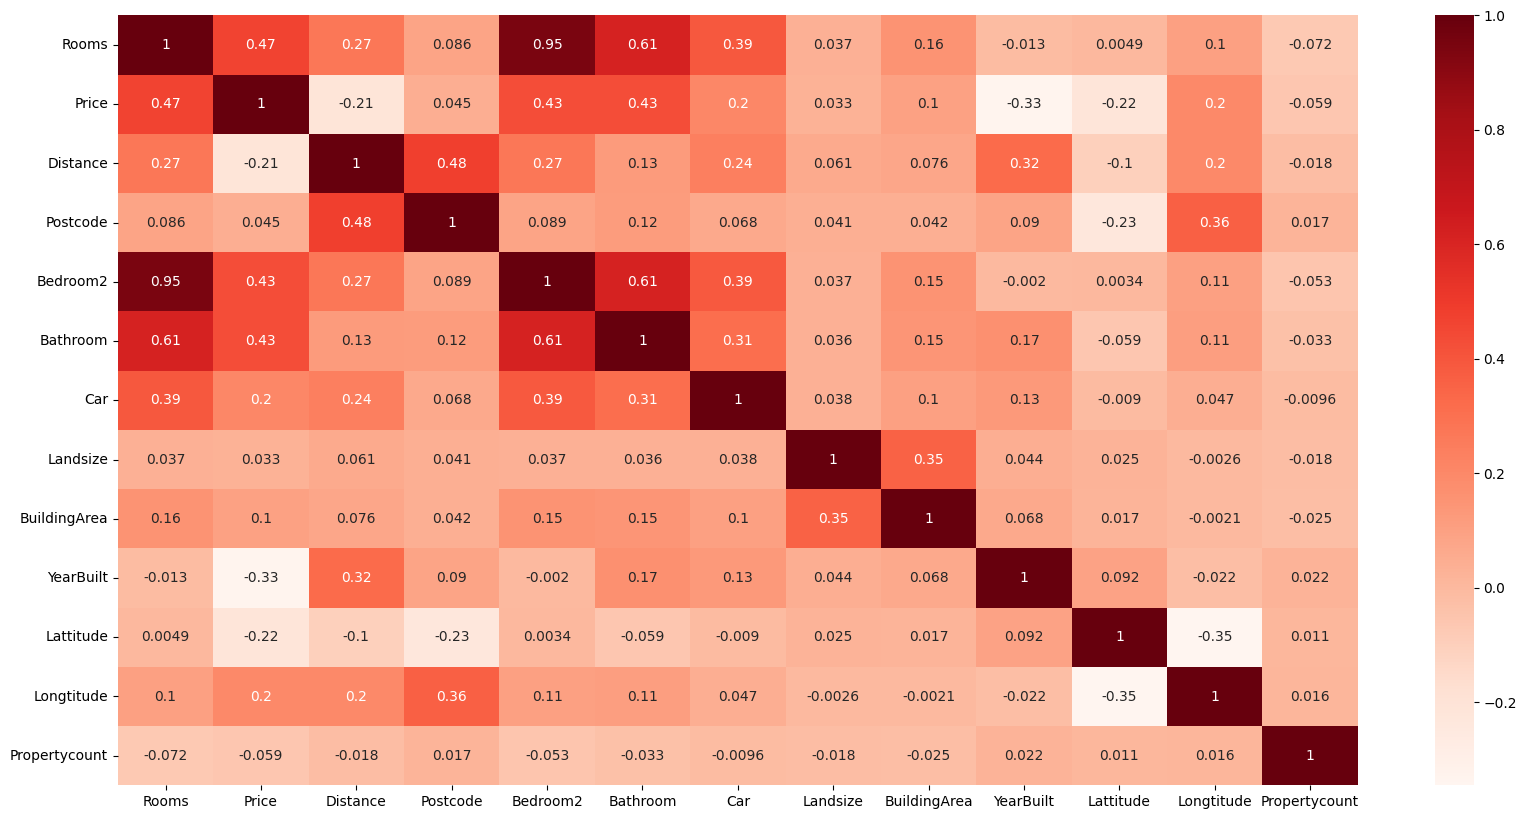

In [8]:
#Checking the correlation between features.
#Features "Rooms" and "Bedroom2" have very high correlation.
corr = df_copy.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="Reds", annot=True);

In [9]:
#Feature "Address" is dropped as it doesn't present any meaningful information and adds noise to the data.
df_copy = df_copy.drop("Address", axis=1)
#Feature "Bedroom2" is also dropped as feature "Rooms" has near identical values.
df_copy = df_copy.drop("Bedroom2", axis=1)
#Features are grouped on the basis of their data types.
cat_cols = df_copy.select_dtypes(include=['object']).columns
num_cols = df_copy.select_dtypes(include=['number']).columns
#And one list is created for numerical feature related operations.
num_feature_cols = df_copy.select_dtypes(include=['number']).columns.difference(["Price"])

In [10]:
#Checking whether there are any duplicates in the data.
df_copy.duplicated().sum()

24

In [11]:
#Identifying duplicate samples.
#Coincidentally, these values also indicate that there are features with many missing values.
df_copy.loc[df_copy.duplicated(keep=False), :]

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1191,Balwyn North,4,h,NaN,SP,Marshall,28/05/2016,9.2,3104.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,7809.0
1192,Balwyn North,4,h,NaN,SP,Marshall,28/05/2016,9.2,3104.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,7809.0
2584,Burwood,4,t,1000050.0,S,Philip,18/06/2016,11.7,3125.0,NaN,NaN,NaN,NaN,NaN,Monash City Council,NaN,NaN,Southern Metropolitan,5678.0
2585,Burwood,4,t,1000050.0,S,Philip,18/06/2016,11.7,3125.0,NaN,NaN,NaN,NaN,NaN,Monash City Council,NaN,NaN,Southern Metropolitan,5678.0
2743,Camberwell,4,h,NaN,S,Marshall,22/05/2016,7.8,3124.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,8920.0
2744,Camberwell,4,h,NaN,S,Marshall,22/05/2016,7.8,3124.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,8920.0
2745,Camberwell,4,h,NaN,S,Marshall,22/05/2016,7.8,3124.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,8920.0
6422,Malvern East,4,h,NaN,S,Jellis,17/09/2016,11.2,3145.0,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,8801.0
6423,Malvern East,4,h,NaN,S,Jellis,17/09/2016,11.2,3145.0,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,8801.0
6604,Maribyrnong,2,u,NaN,W,hockingstuart,22/05/2016,8.7,3032.0,NaN,NaN,NaN,NaN,NaN,Maribyrnong City Council,NaN,NaN,Western Metropolitan,4918.0


In [12]:
#Removing the duplicate samples and keeping the first occurences.
df_copy = df_copy.drop_duplicates()
#Resetting the index values of the modified DataFrame and replacing the old index values with new values.
df_copy = df_copy.reset_index(drop=True)

In [13]:
#Getting a more detailed overview of data to understand data distribution.
#Comparing values from different columns can highlight potential outliers.
#Features "Distance", "Landsize" and "BuildingArea" have 0 values. Different methods could be used to deal with them based on their overall impact on the data.
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,34833.0,3.031034e+00,0.969971,1.00000,2.00000,3.0000,4.000000e+00,1.600000e+01
Price,27237.0,1.050246e+06,641552.339232,85000.00000,635000.00000,870000.0000,1.295000e+06,1.120000e+07
Distance,34832.0,1.118497e+01,6.786942,0.00000,6.40000,10.3000,1.400000e+01,4.810000e+01
Postcode,34832.0,3.116029e+03,108.936190,3000.00000,3051.00000,3103.0000,3.156000e+03,3.978000e+03
Bathroom,26630.0,1.624747e+00,0.724177,0.00000,1.00000,2.0000,2.000000e+00,1.200000e+01
Car,26128.0,1.728835e+00,1.010789,0.00000,1.00000,2.0000,2.000000e+00,2.600000e+01
Landsize,23046.0,5.936072e+02,3398.915462,0.00000,224.00000,521.0000,6.700000e+02,4.330140e+05
BuildingArea,13741.0,1.602516e+02,401.281270,0.00000,102.00000,136.0000,1.880000e+02,4.451500e+04
YearBuilt,15550.0,1.965288e+03,37.328340,1196.00000,1940.00000,1970.0000,2.000000e+03,2.106000e+03
Lattitude,26880.0,-3.781063e+01,0.090281,-38.19043,-37.86295,-37.8076,-3.775409e+01,-3.739020e+01


In [14]:
#Checking the distribution of values for each numerical feature.
#Feature "Landsize" has a highly skewed distribution of values.
for col in num_cols:
  print(col, "\n", df_copy[col].value_counts(), "\n", sep="")

Rooms
3     15077
2      8325
4      7947
5      1737
1      1478
6       204
7        32
8        19
10        6
9         4
12        3
16        1
Name: Rooms, dtype: int64

Price
1100000.0    235
600000.0     235
650000.0     219
800000.0     216
1300000.0    210
            ... 
1452000.0      1
2555000.0      1
949500.0       1
426500.0       1
1605500.0      1
Name: Price, Length: 2871, dtype: int64

Distance
11.2    1418
13.8     681
9.2      664
10.5     660
7.8      660
        ... 
31.4       1
22.9       1
33.0       1
29.5       1
32.6       1
Name: Distance, Length: 215, dtype: int64

Postcode
3073.0    844
3046.0    638
3020.0    617
3121.0    612
3165.0    583
         ... 
3428.0      1
3770.0      1
3786.0      1
3139.0      1
3159.0      1
Name: Postcode, Length: 211, dtype: int64

Bathroom
1.0     12969
2.0     11064
3.0      2180
4.0       269
5.0        77
0.0        46
6.0        16
7.0         4
8.0         3
12.0        1
9.0         1
Name: Bathroom, dtype: in

In [15]:
#Checking the percentages of 0 values for selected columns.
percentage1 = (df_copy['BuildingArea'] == 0).sum() / len(df) * 100
percentage2 = (df_copy['Distance'] == 0).sum() / len(df) * 100
percentage2 = (df_copy['Landsize'] == 0).sum() / len(df) * 100
print(f"Building Area 0 values: {percentage1} | Distance 0 values: {percentage2} | Land Size 0 values: {percentage2}")

Building Area 0 values: 0.21803368046590355 | Distance 0 values: 6.991422095992196 | Land Size 0 values: 6.991422095992196


In [16]:
#Checking how many values are missing in each feature.
df_copy.isnull().sum()

Suburb               0
Rooms                0
Type                 0
Price             7596
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bathroom          8203
Car               8705
Landsize         11787
BuildingArea     21092
YearBuilt        19283
CouncilArea          3
Lattitude         7953
Longtitude        7953
Regionname           3
Propertycount        3
dtype: int64

In [17]:
#A significant portion of some features are missing. There are 3 possible course of actions:
#1 Features with high number of missing values can be dropped, potentially losing valuable data.
#2 Imputation techniques can be used, potentially leading to a more skewed distribution of data based on the imputation technique.
#3 Samples with missing values can be dropped, potentially leading to a significant reduction in DataFrame size.
df_copy.isnull().sum() / len(df_copy) * 100

Suburb            0.000000
Rooms             0.000000
Type              0.000000
Price            21.806907
Method            0.000000
SellerG           0.000000
Date              0.000000
Distance          0.002871
Postcode          0.002871
Bathroom         23.549508
Car              24.990670
Landsize         33.838601
BuildingArea     60.551776
YearBuilt        55.358424
CouncilArea       0.008613
Lattitude        22.831797
Longtitude       22.831797
Regionname        0.008613
Propertycount     0.008613
dtype: float64

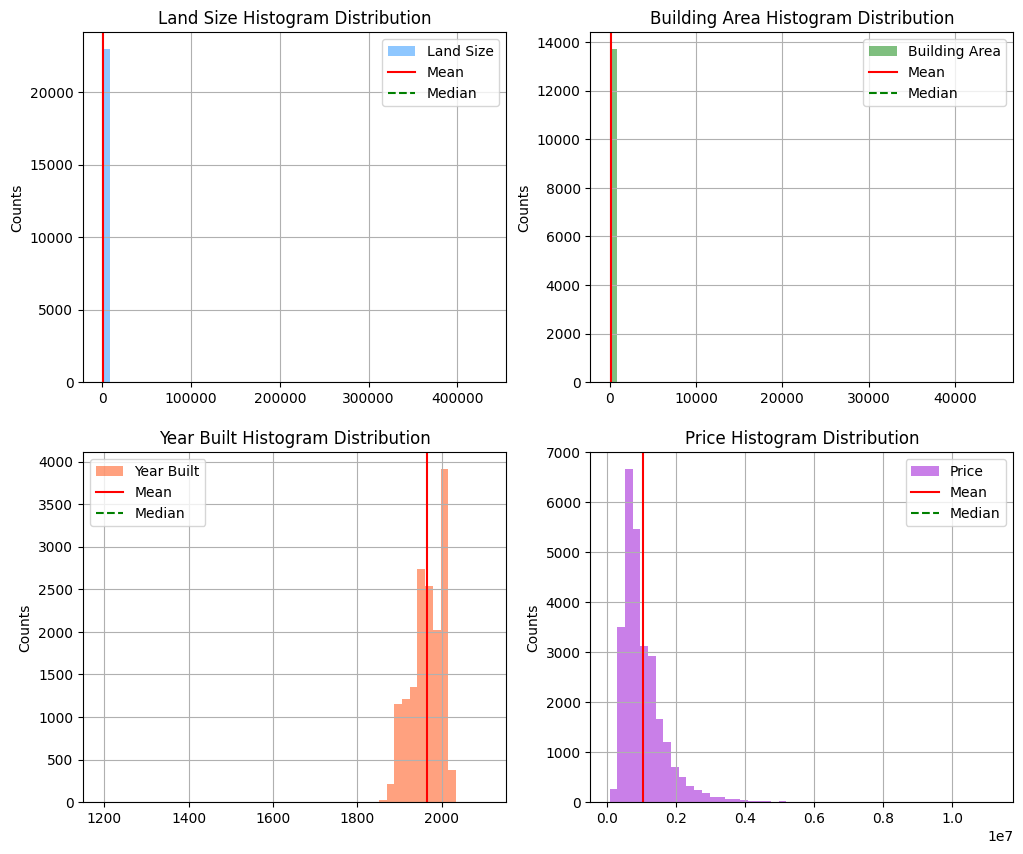

In [18]:
#Distribution of selected 4 columns before data processing.
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df_copy['Landsize'].hist(bins=50, color="dodgerblue", label='Land Size', alpha=0.5)
plt.axvline(np.mean(df_copy['Landsize']), ls='-', c='r', label="Mean")
plt.axvline(np.median(df_copy['Landsize']), ls='--', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Land Size Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 2)
df_copy['BuildingArea'].hist(bins=50, color="green", label='Building Area', alpha=0.5)
plt.axvline(np.mean(df_copy['BuildingArea']), ls='-', c='r', label="Mean")
plt.axvline(np.median(df_copy['BuildingArea']), ls='--', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Building Area Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 3)
df_copy['YearBuilt'].hist(bins=50, color="orangered", label='Year Built', alpha=0.5)
plt.axvline(np.mean(df_copy['YearBuilt']), ls='-', c='r', label="Mean")
plt.axvline(np.median(df_copy['YearBuilt']), ls='--', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Year Built Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 4)
df_copy['Price'].hist(bins=50, color="darkviolet", label='Price', alpha=0.5)
plt.axvline(np.mean(df_copy['Price']), ls='-', c='r', label="Mean")
plt.axvline(np.median(df_copy['Price']), ls='--', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Price Histogram Distribution");
plt.legend()

In [19]:
#0 values for "Landsize", "BuildingArea" and "Distance" are classified as missing values.
df_copy['Landsize'].replace(0, np.nan, inplace=True)
df_copy['BuildingArea'].replace(0, np.nan, inplace=True)
df_copy['Distance'].replace(0, np.nan, inplace=True)

In [20]:
#Function for detecting outliers with z-score method for each numerical feature and clearing them..
def zscore_clear(df, num_cols, threshold):
  for col in num_cols:
    std_dev = df[col].std()
    mean = df[col].mean()
    mode = df[col].mode()
    df["z_scores"] = (df[col] - mean) / std_dev
    df[col][abs(df["z_scores"]) > threshold] = np.nan

In [ ]:
#Threshold for z-scores is set to 3 based on prior testing.
zscore_clear(df_copy, num_cols, 3)
#Dropping the "z_scores" feature added by the function to maintain the structure of the DataFrame.
df_copy = df_copy.drop("z_scores", axis=1)

In [22]:
#Dropping missing label values to make predictions more accurate.
df_copy.dropna(subset=['Price'], inplace=True)

In [23]:
#Clearing far-away values for imputation. Values are selected based on a rule of thumb.
#Replacing these values with KNN estimates slightly increases model performance.
df_copy.loc[df_copy['Landsize'] > 1000] = np.nan
df_copy.loc[df_copy['BuildingArea'] > 400] = np.nan
df_copy.loc[df_copy['YearBuilt'] < 1880] = np.nan

In [24]:
#Replacing NaN values of categorical variables with the mode of the respective column.
for col in cat_cols:
  df_copy[col] = df_copy[col].fillna(df_copy[col].mode().iloc[0])
#Estimating the missing values of numerical features with KNN for imputation. Nearest 20 columns are taken into consideration.
num_imputer = KNNImputer(n_neighbors=40)
df_copy[num_cols] = num_imputer.fit_transform(df_copy[num_cols])

In [25]:
#Checking for leftover NaN values.
df_copy.isnull().sum()

Suburb           0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

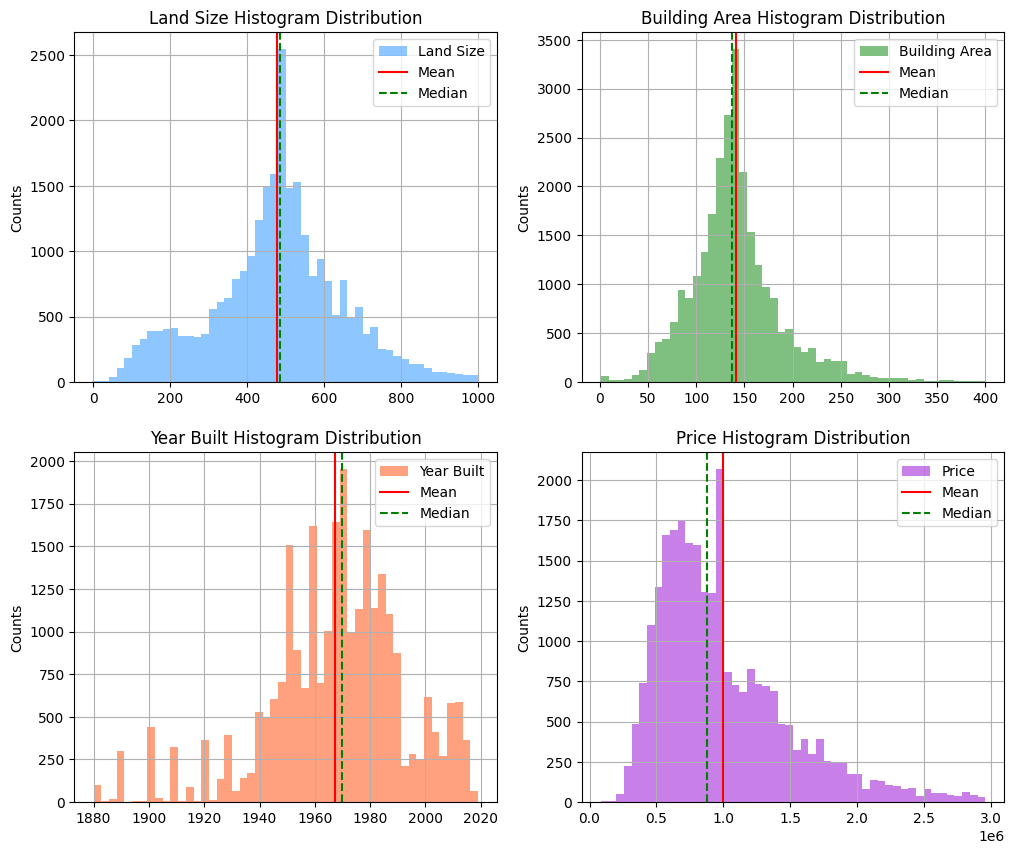

In [26]:
#Distribution of selected 4 columns after data processing.
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df_copy['Landsize'].hist(bins=50, color="dodgerblue", label='Land Size', alpha=0.5)
plt.axvline(np.mean(df_copy['Landsize']), ls='-', c='r', label="Mean")
plt.axvline(np.median(df_copy['Landsize']), ls='--', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Land Size Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 2)
df_copy['BuildingArea'].hist(bins=50, color="green", label='Building Area', alpha=0.5)
plt.axvline(np.mean(df_copy['BuildingArea']), ls='-', c='r', label="Mean")
plt.axvline(np.median(df_copy['BuildingArea']), ls='--', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Building Area Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 3)
df_copy['YearBuilt'].hist(bins=50, color="orangered", label='Year Built', alpha=0.5)
plt.axvline(np.mean(df_copy['YearBuilt']), ls='-', c='r', label="Mean")
plt.axvline(np.median(df_copy['YearBuilt']), ls='--', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Year Built Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 4)
df_copy['Price'].hist(bins=50, color="darkviolet", label='Price', alpha=0.5)
plt.axvline(np.mean(df_copy['Price']), ls='-', c='r', label="Mean")
plt.axvline(np.median(df_copy['Price']), ls='--', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Price Histogram Distribution");
plt.legend()

In [27]:
#Correlations between features and target.
correlations_with_price = df_copy.corrwith(df_copy['Price'])
correlations_with_price.sort_values(ascending=False)

<ipython-input-27-45bc0175ed12>:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_with_price = df_copy.corrwith(df_copy['Price'])


Price            1.000000
BuildingArea     0.690021
Rooms            0.463015
Bathroom         0.401914
Longtitude       0.234629
Landsize         0.219360
Car              0.213793
Postcode         0.195749
Propertycount   -0.020552
Distance        -0.205431
Lattitude       -0.324913
YearBuilt       -0.509953
dtype: float64

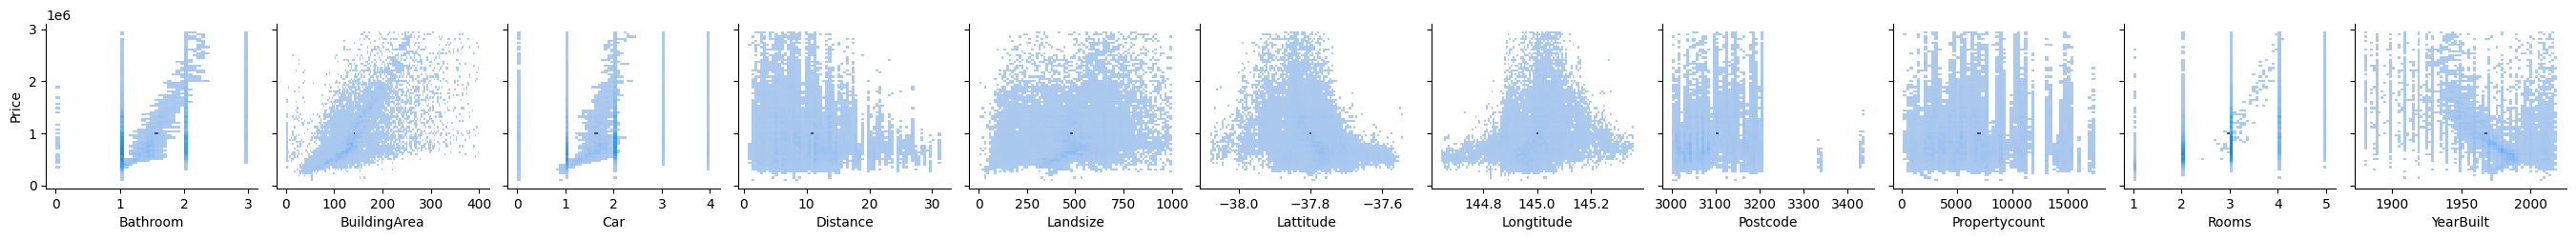

In [28]:
#Pair plots showing the relationship between numerical features and target.
sns.pairplot(df_copy, x_vars=num_feature_cols, y_vars=['Price'], kind="hist")
plt.show()

<ipython-input-29-7646aaf78254>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_copy.corr()


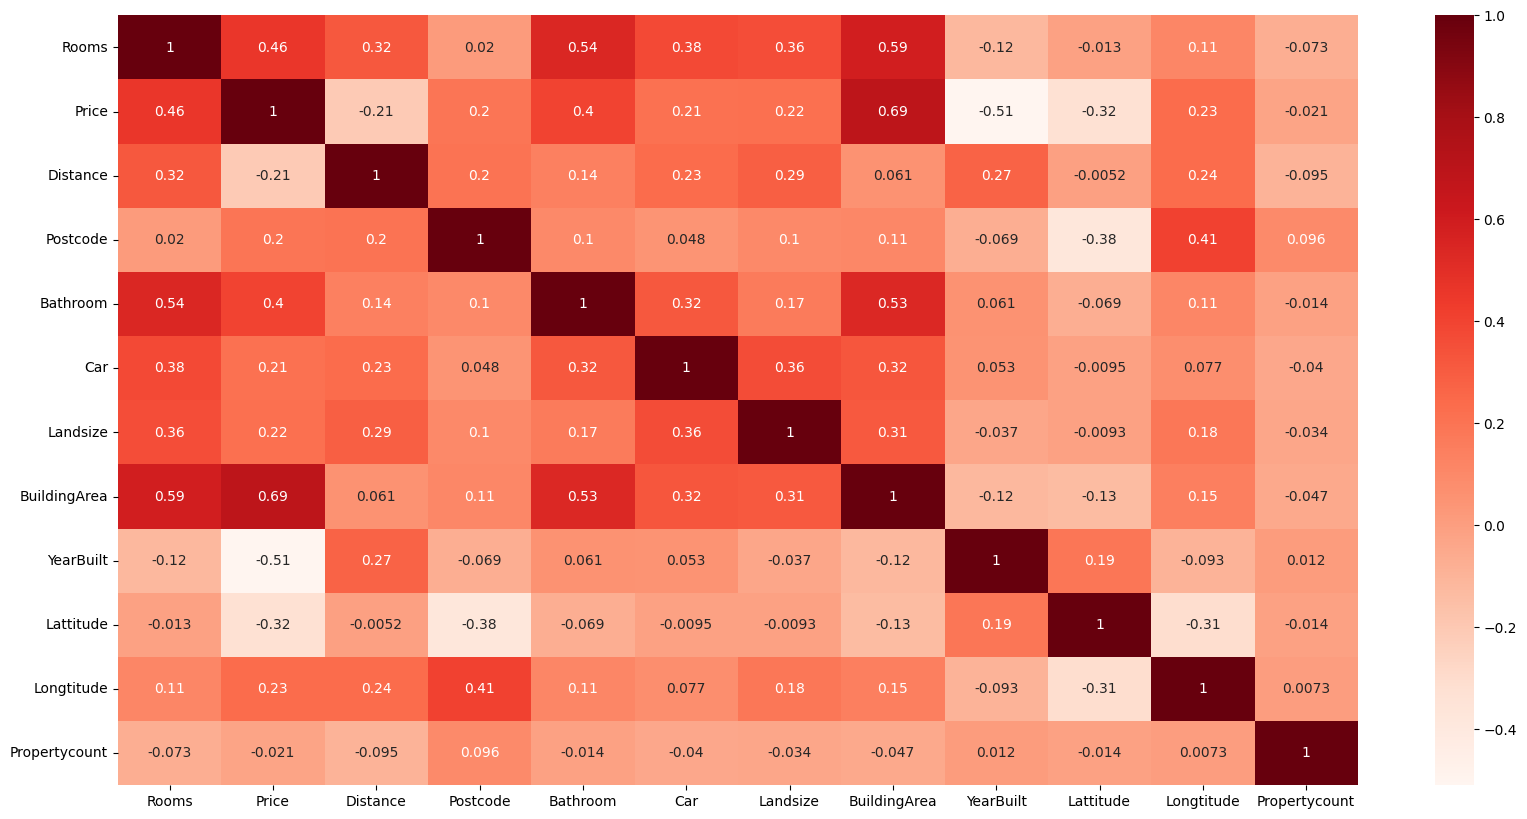

In [29]:
#Heatmap of feature and label correlations after the data has been processed.
#Features "Propertycount" has a relatively low correlation with target. Dropping it could reduce noise in data but also lead to loss of valuable information.
corr = df_copy.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="Reds", annot=True);

In [30]:
#Categorical variables "Suburb" and "SellerG" have many unique values and therefore increase model dimension by a lot when encoded with one hot encoding.
#Despite not having any ordinal relationships among its values, these two columns are encoded with label encoder to reduce DataFrame dimension, increase model speed and decrease memory usage.
#Remaining categorical columns are encoded with one hot encoding as they have fewer values.
label_encoder = LabelEncoder()
cat_cols_label = ["Suburb", "SellerG"]
cat_cols_one_hot = [col for col in cat_cols if col not in cat_cols_label]
for col in cat_cols_label:
  df_copy[col] = label_encoder.fit_transform(df_copy[col])
df_copy = pd.get_dummies(df_copy, columns=cat_cols_one_hot, drop_first=True)
df_copy.head()

,Suburb,Rooms,Price,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,...,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
1,0,2.0,1480000.0,31,2.5,3067.0,1.0,1.0,202.0,177.375000,...,0,1,0,0,1,0,0,0,0,0
2,0,2.0,1035000.0,31,2.5,3067.0,1.0,0.0,156.0,79.000000,...,0,1,0,0,1,0,0,0,0,0
4,0,3.0,1465000.0,31,2.5,3067.0,2.0,0.0,134.0,150.000000,...,0,1,0,0,1,0,0,0,0,0
5,0,3.0,850000.0,31,2.5,3067.0,2.0,1.0,94.0,159.423378,...,0,1,0,0,1,0,0,0,0,0
6,0,4.0,1600000.0,202,2.5,3067.0,1.0,2.0,120.0,142.000000,...,0,1,0,0,1,0,0,0,0,0


In [31]:
#Assigning features to "X" and label to "y" for train-test split.
X = df_copy.drop("Price", axis=1)
y = df_copy.loc[:,"Price"]

In [32]:
#Scaling values of numerical features to make them more consistent and increase model speed.
scaler = MinMaxScaler()
num_features = X.select_dtypes(include=['number'])
scaled_features = scaler.fit_transform(num_features)
scaled_df = pd.DataFrame(scaled_features, index=num_features.index, columns=num_features.columns)
X.update(scaled_df)
X.head()

,Suburb,Rooms,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
1,0.0,0.25,0.090643,0.058632,0.152968,0.333333,0.25,0.201201,0.442043,0.543345,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.25,0.090643,0.058632,0.152968,0.333333,0.00,0.155155,0.195489,0.143885,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.50,0.090643,0.058632,0.152968,0.666667,0.00,0.133133,0.373434,0.143885,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.50,0.090643,0.058632,0.152968,0.666667,0.25,0.093093,0.397051,0.658273,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.75,0.590643,0.058632,0.152968,0.333333,0.50,0.119119,0.353383,0.964029,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
#Final shape of the DataFrame:
df_copy.shape

(26763, 136)

In [34]:
#Splitting "X" & "y" DataFrames into train and test sets. Random state is used to compare results during testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [ ]:
#Regression models:
lasso = Lasso()
linear = LinearRegression()
ridge = Ridge()
en = ElasticNet()
kn  = KNeighborsRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor(n_estimators=5, learning_rate=1.2, loss='exponential', random_state=2)
xgb = XGBRegressor()
lgbm = LGBMRegressor()
cb = CatBoostRegressor()
#Training:
lasso.fit(X_train, y_train)
linear.fit(X_train, y_train)
ridge.fit(X_train, y_train)
en.fit(X_train, y_train)
kn.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
ada.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
cb.fit(X_train, y_train)
#Predictions:
lasso_pred = lasso.predict(X_test)
linear_pred = linear.predict(X_test)
ridge_pred = ridge.predict(X_test)
en_pred = en.predict(X_test)
kn_pred = kn.predict(X_test)
rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)
ada_pred = ada.predict(X_test)
xgb_pred = xgb.predict(X_test)
lgbm_pred = lgbm.predict(X_test)
cb_pred = cb.predict(X_test)
#Categorizing:
model_preds = {
    "Lasso": lasso_pred,
    "Linear": linear_pred,
    "Ridge": ridge_pred,
    "Elastic Net": en_pred,
    "K Neighbors": kn_pred,
    "Random Forest": rf_pred,
    "Gradient Boosting": gb_pred,
    "Ada Boost": ada_pred,
    "XGB": xgb_pred,
    "LGM": lgbm_pred,
    "Cat Boost": cb_pred}

In [36]:
#Performance results:
for model, pred in model_preds.items():
  print(f"{model}:\n=========================")
  print(f"MAE: {mean_absolute_error(y_test, pred):.0f}")
  print(f"MSE: {mean_squared_error(y_test, pred):.0f}")
  print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.0f}")
  print(f"R2: {r2_score(y_test, pred):.3f}", end="\n\n")

Lasso:
MAE: 162690
MSE: 52658708662
RMSE: 229475
R2: 0.788

Linear:
MAE: 162694
MSE: 52657903423
RMSE: 229473
R2: 0.788

Ridge:
MAE: 162740
MSE: 52688307725
RMSE: 229539
R2: 0.788

Elastic Net:
MAE: 322979
MSE: 181140766134
RMSE: 425606
R2: 0.271

K Neighbors:
MAE: 229659
MSE: 108269750726
RMSE: 329044
R2: 0.564

Random Forest:
MAE: 93682
MSE: 26053190524
RMSE: 161410
R2: 0.895

Gradient Boosting:
MAE: 112661
MSE: 31728787529
RMSE: 178126
R2: 0.872

Ada Boost:
MAE: 172823
MSE: 60623954048
RMSE: 246219
R2: 0.756

XGB:
MAE: 95633
MSE: 22945799071
RMSE: 151479
R2: 0.908

LGM:
MAE: 96121
MSE: 23341685442
RMSE: 152780
R2: 0.906

Cat Boost:
MAE: 91882
MSE: 20875842371
RMSE: 144485
R2: 0.916



In [ ]:
#Cross validating top 3 performing models to see how they generalize to data.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_r2 = cross_val_score(xgb, X, y, cv=kf, scoring=make_scorer(r2_score))
lgbm_r2 = cross_val_score(lgbm, X, y, cv=kf, scoring=make_scorer(r2_score))
cb_r2 = cross_val_score(cb, X, y, cv=kf, scoring=make_scorer(r2_score))

In [40]:
xgb_r2 = np.round(xgb_r2, 3)
lgbm_r2 = np.round(lgbm_r2, 3)
cb_r2 = np.round(cb_r2, 3)
print(f"XGB R2 scores: {xgb_r2}", end="\n\n")
print(f"LGM R2 scores: {lgbm_r2}", end="\n\n")
print(f"Cat Boost R2 scores: {cb_r2}", end="\n\n")

XGB R2 scores: [0.913 0.906 0.911 0.91  0.9  ]

LGM R2 scores: [0.909 0.903 0.908 0.912 0.903]

Cat Boost R2 scores: [0.919 0.914 0.918 0.918 0.913]



In [ ]:
"""
This program can be improved by:
1. Using a more robust imputation technique such as neural networks to identify the patterns between numerical features and better estimate them.
2. Using such technique on categorical columns instead of replacing missing values with mode.
3. Finding a way to accurately estimate missing price values instead of dropping them and benefiting from a larger portion of the original dataset.
4. Finding a better method to find the initial outliers from the skewed data distributions.
5. Reducing the number of "n_neighbors" for KNN imputation to reduce processing time.